# Deep Learning

## Build a Traffic Sign Recognition Classifier Using TensorFlow

---

## Step 1: Dataset Exploration

First we visualize the German Traffic Signs Dataset. In this section, we plot the traffic signs images and a histogram containing the count of each sign in the dataset.

The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
# Load required libraries
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split
from tqdm import tqdm
from scipy import misc
import os
import pandas as pd

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15,10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load pickled data

# Open training and testing data files
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
# To start off let's do a basic data summary

# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# The shape of an image
image_shape = X_train.shape[1:]

# Number of classes in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Pictures of the signs

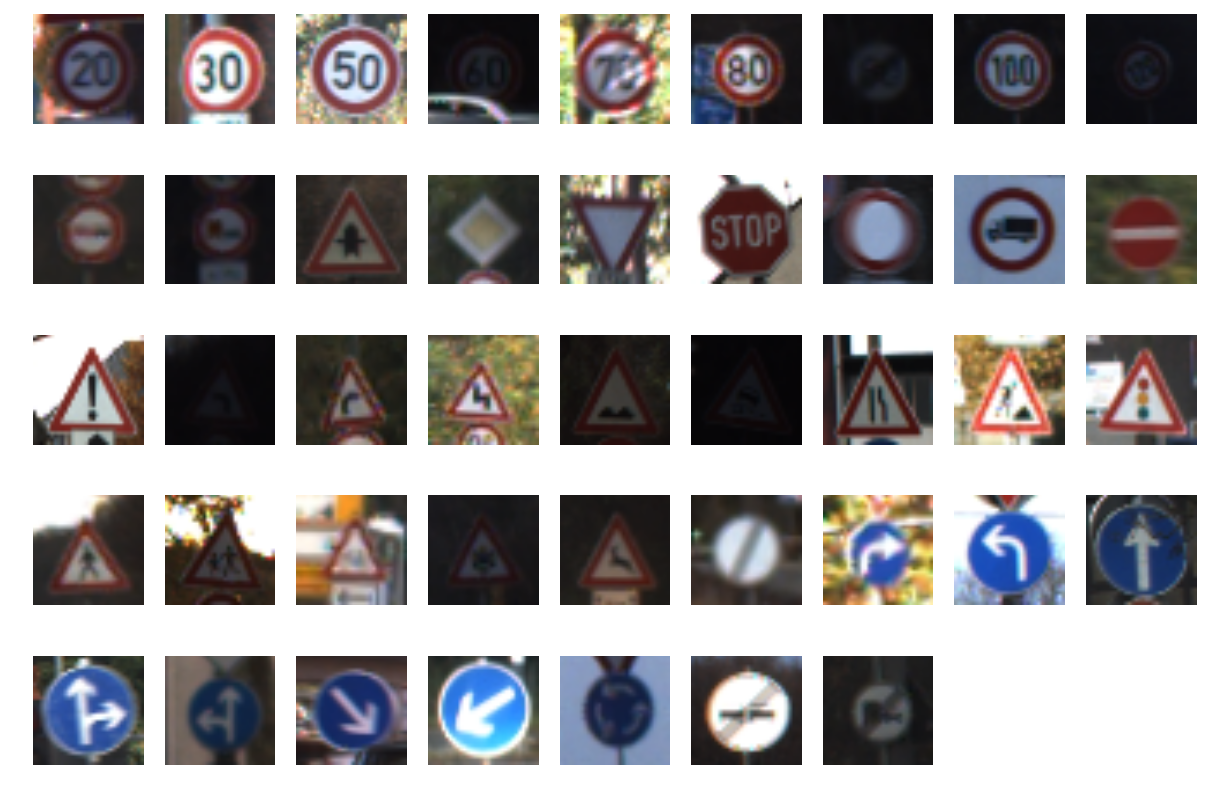

In [5]:
traffic_sign = []

for i in range(0,n_classes):
    plt.subplot(5,9,i+1)
    traffic_sign.append(X_test[np.where( y_test == i )[0][0],:,:,:].squeeze())
    img = plt.imshow(X_test[np.where(y_test == i)[0][0],:,:,:].squeeze())
    plt.axis('off')

### Count of each sign

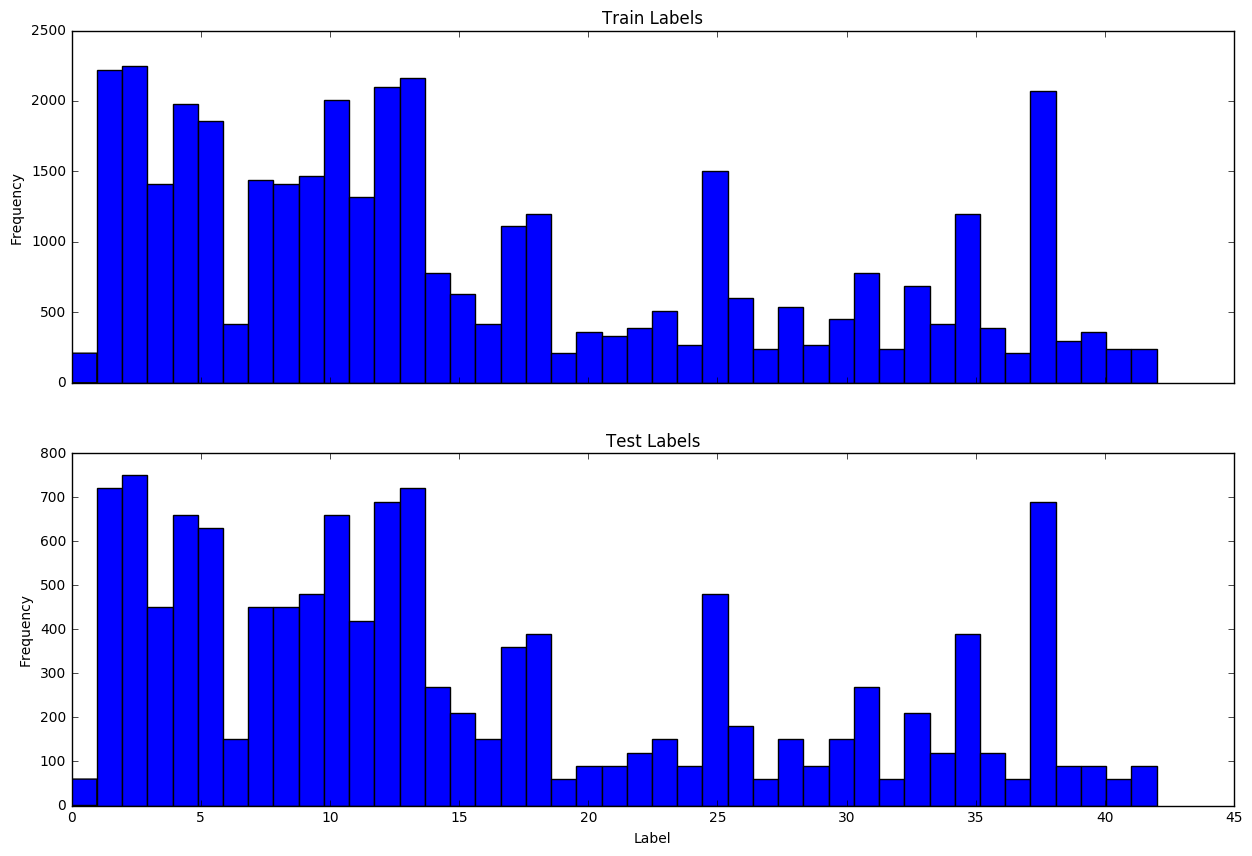

In [6]:
# Plot histogram of labels in training and test set
f, axarr = plt.subplots(2, sharex = True)
axarr[0].hist(y_train, bins = n_classes)
axarr[0].set_title('Train Labels')
axarr[0].set_ylabel('Frequency')
axarr[1].hist(y_test, bins = n_classes)
axarr[1].set_title('Test Labels')
axarr[1].set_xlabel('Label')
axarr[1].set_ylabel('Frequency')

----

## Step 2: Design and Test a Model Architecture

We now design and implement a deep learning model that learns to recognize traffic signs. The model is trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Implementation

### Implement Min-Max scaling to convert image to greyscale

In [7]:
# Implement Min-Max scaling for greyscale image data
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + (((image_data - greyscale_min)*(b - a))/(greyscale_max - greyscale_min))

X_test_n = numpy.zeros((X_test.shape[0], X_test.shape[1]*X_test.shape[2], X_test.shape[3]), dtype=float)
X_train_n = numpy.zeros((X_train.shape[0], X_train.shape[1]*X_train.shape[2], X_train.shape[3]), dtype=float)

for i in range (X_test.shape[3]):
    X_test_n[:,:,i] = normalize_greyscale(X_test[:,:,:,i].reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
    X_train_n[:,:,i] = normalize_greyscale(X_train[:,:,:,i].reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
    
X_test_n = X_test_n.reshape(X_test_n.shape[0], X_test_n.shape[1]*X_test_n.shape[2])
X_train_n = X_train_n.reshape(X_train_n.shape[0], X_train_n.shape[1]*X_train_n.shape[2])

### Apply One-Hot Encoding

In [8]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Convert to float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

### Techniques used to preprocess the data  

Whenever possible, we want our variables to have 0 mean and equal variance when doing optimization. One way we can do this on images is to convert the images to greyscale. This has the effect of reducing the overall variation in the dataset. However, we would like to preserve the variation between colors so the normalization was performed individually on each color. 

Also, in order to convert labels into numbers, I applied One-Hot Encoding.

### Split the data into training and validation sets

In [9]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_n,
    y_train,
    test_size=0.3,
    random_state=832289)

### Setting up the training and validation data for the model  

The train_test_split function was used to separate the data in training and testing datasets. I went with the conventional method of using 70% of the data to train and 30% to test.

### Architecture

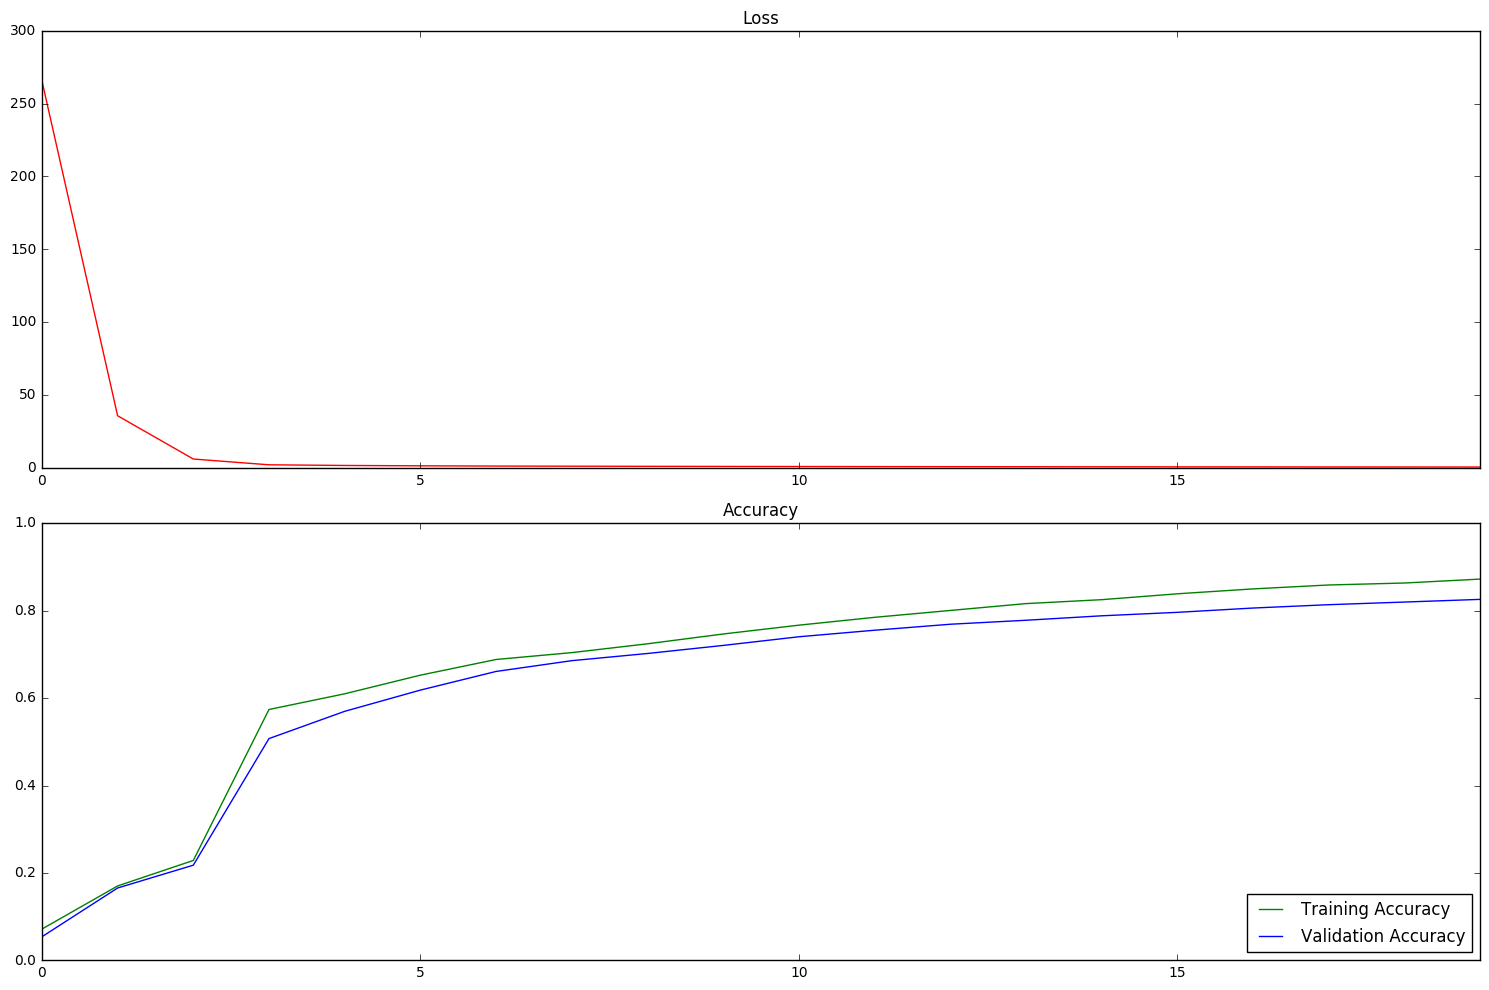

Validation accuracy at 0.7328583002090454


In [11]:
# Learning Parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 1000

# Size of inputs
n_input = train_features.shape[1]  
n_classes = train_labels.shape[1]

# Hidden Layer Parameters
n_hidden_layer1 = n_input # layer number of features
n_hidden_layer2 = n_input # layer number of features

# Store layers weight & bias
weights = {
    'hidden_layer1': tf.Variable(tf.random_normal([n_input, n_hidden_layer1], mean = 0, stddev = 0.01)),
    'hidden_layer2': tf.Variable(tf.random_normal([n_hidden_layer1, n_hidden_layer2], mean = 0, stddev = 0.01)),
    'out': tf.Variable(tf.random_normal([n_hidden_layer2, n_classes]))
}
biases = {
    'hidden_layer1': tf.Variable(tf.random_normal([n_hidden_layer1], mean = 0, stddev = 0.01)),
    'hidden_layer2': tf.Variable(tf.random_normal([n_hidden_layer2], mean = 0, stddev = 0.01)),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Hidden layers with RELU activation
layer_1 = tf.add(tf.matmul(x, weights['hidden_layer1']), biases['hidden_layer1'])
layer_1 = tf.nn.relu(layer_1)

layer_2 = tf.add(tf.matmul(x, weights['hidden_layer2']), biases['hidden_layer2'])
layer_2 = tf.nn.relu(layer_2)

# Output layer with linear activation
logits = tf.matmul(layer_2, weights['out']) + biases['out']

prediction = tf.nn.softmax(logits)
predict = tf.argmax(logits, 1) 

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#Define accuracy 
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

#Initialize storage variables
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# Initialize tf session
sess = tf.Session()
sess.run(tf.initialize_all_variables())

#Run for all epochs
for epoch in range(training_epochs):
    
    # The training cycle
    for batch_start in range(0, train_labels.shape[0], batch_size):
        batch_finish = batch_start + batch_size
        batch_features = train_features[batch_start:batch_finish]
        batch_labels = train_labels[batch_start:batch_finish]
        
        # Run optimizer
        sess.run(optimizer, feed_dict = {x: batch_features, y: batch_labels})
    
    loss_out = sess.run(loss, feed_dict={x: batch_features, y: batch_labels})
    acc = sess.run(accuracy, feed_dict = {x: batch_features, y: batch_labels})       
    loss_batch.append([loss_out])
    train_acc_batch.append([acc])

    acc = sess.run(accuracy, feed_dict = {x: valid_features, y:  valid_labels})              
    valid_acc_batch.append([acc])

# Check accuracy against Validation data
validation_accuracy = sess.run(accuracy, feed_dict = {x: X_test_n, y:  y_test})

# Plot Loss and Accuracy
epochs = np.arange(training_epochs)
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(epochs, loss_batch, 'r')
loss_plot.set_xlim([epochs[0], epochs[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(epochs, train_acc_batch, 'g', label='Training Accuracy')
acc_plot.plot(epochs, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([epochs[0], epochs[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

### Architecture  

The model used in this classification task is the Feedforward Neural Network. It contains 2 hidden layers. Within each layer, ReLU is used to convert the linear models into non-linear models. The cost function is determined using the softmax_cross_entropy_with_logits method. 

I only tried the Feedforward Network, but the Convolution Network is also appropriate to solve this problem. Although it would provide more accurate results, the implementation is more complex.

The size of each layer was 3072.

### Model Training  

After testing several methods for the optimizer, I settled on using the AdamOptimizer method for the optimizer since it produced the most accurate results. I used a learning rate of 0.001, 20 training epochs and a batch size of 1000.

### Approach  

The approach that I took followed very similarly to the Deep Neural Network in TensorFlow lesson. Because the example in the lesson focused on classifying letters, I made several tweeks to accomodate the more complex nature of this problem. Some noticable differences include having 2 hidden layers, using a different optimizer and different learning parameters to allow for better tuning.

---

## Step 3: Test Model on New Images

### Implementation

(-0.5, 31.5, 31.5, -0.5)

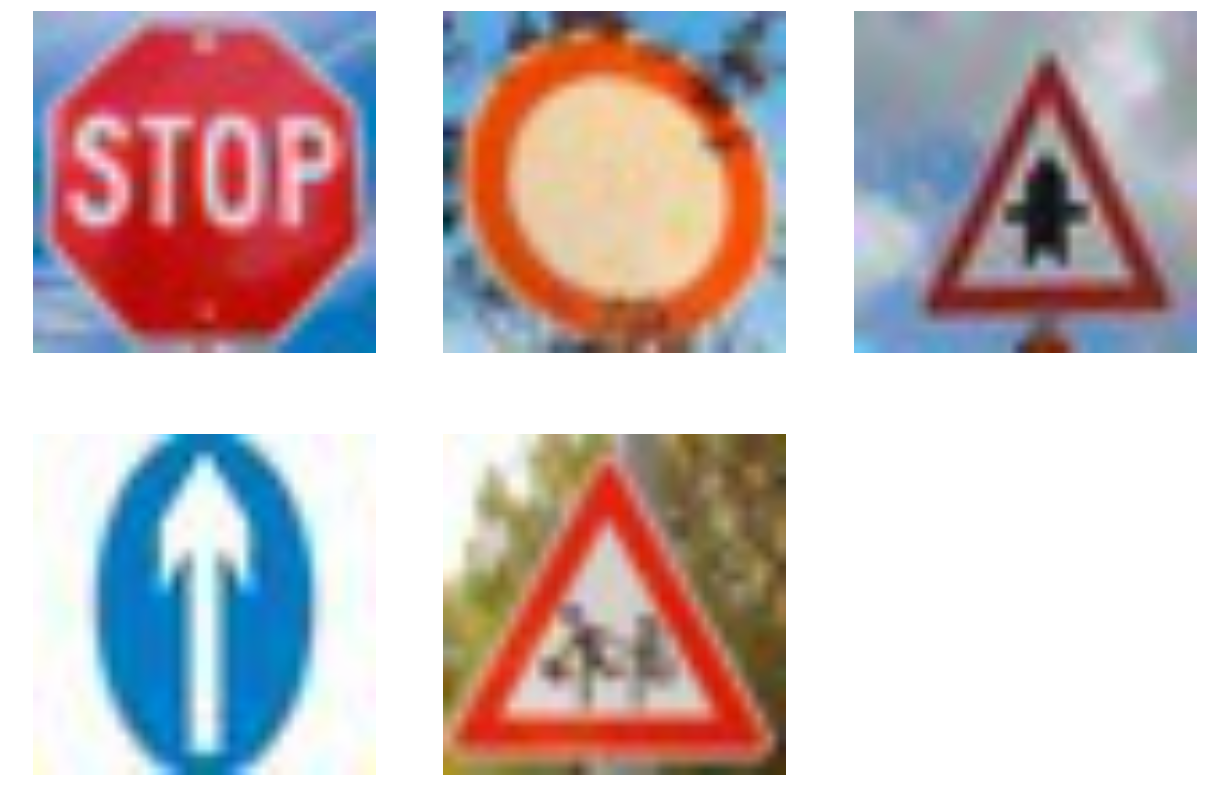

In [15]:
# Load the data
signs = []
for filename in os.listdir('testsigns_'):
    sign = plt.imread('testsigns_/' + filename)
    signs.append(sign)

# Plot the signs
fig = plt.figure()
fig.add_subplot(2,3,1)
plt.axis('off')
plt.imshow(signs[0])
fig.add_subplot(2,3,2)
plt.axis('off')
plt.imshow(signs[1])
fig.add_subplot(2,3,3)
plt.axis('off')
plt.imshow(signs[2])
fig.add_subplot(2,3,4)
plt.axis('off')
plt.imshow(signs[3])
fig.add_subplot(2,3,5)
plt.axis('off')
plt.imshow(signs[4])
plt.axis('off')

### New Candidates  

The second sign has a lot of obstruction to it with tree branches covering parts of the sign, in addition to containing different colors than those in the training set. I suspect that this one will be difficult to classify by the algorithm. There is also a slight tilt in a couple of the signs, thereby causing classification issues. Also, at this resolution and size, the images look quite blurred.

[15 15 11 35 28]


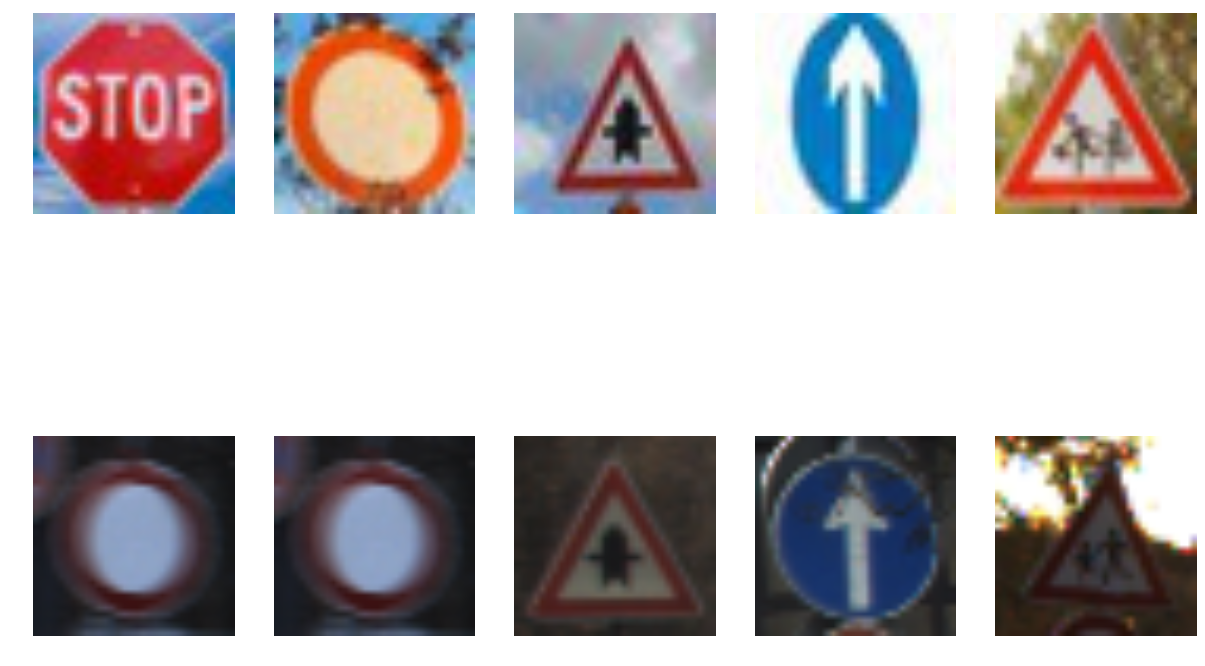

In [16]:
# Preprocess the images and run the signs through the prediction algorithm to test performance
X = np.array(signs)
X_mine = numpy.zeros((X.shape[0],X.shape[1]*X.shape[2],X.shape[3]), dtype=float)

for i in range (X.shape[3]):
    X_mine[:,:,i] = normalize_greyscale(X[:,:,:,i].reshape(X.shape[0], X.shape[1]*X.shape[2]))
    
X_mine = X_mine.reshape(X_mine.shape[0], X_mine.shape[1]*X_mine.shape[2])

preds = sess.run(predict, feed_dict = {x: X_mine})
print(preds)

fig = plt.figure()
for i in [1,2,3,4,5]:
    fig.add_subplot(2,5,i)
    plt.imshow(X[i-1,:,:,:]) 
    plt.axis('off')
    fig.add_subplot(2,5,i+5)
    plt.imshow(traffic_sign[preds[i-1]])
    plt.axis('off')

### Performance on Test Images  

The model was able to predict 2 correctly out of 5. This accuracy level is considerably less than the test dataset. 
However, with a little more tuning, I believe that the accuracy can be considerably improved. The incorrect classifications are actually quite similar the correct image in most cases.

[[  8.98886383e-01   5.69499619e-02   1.34843495e-02   9.74598248e-03
    6.34937175e-03]
 [  8.72398078e-01   6.03378862e-02   4.15350497e-02   1.11947525e-02
    2.74483161e-03]
 [  8.77143264e-01   7.44165927e-02   1.66356042e-02   1.16848461e-02
    4.46584728e-03]
 [  9.98887241e-01   1.10499526e-03   6.34411663e-06   6.63920900e-07
    2.92618296e-07]
 [  4.69803959e-01   4.38696295e-01   5.44482060e-02   1.90260801e-02
    8.16036016e-03]]
[[15  1  9 14 25]
 [15  0 26  1 12]
 [11 30  7  1 21]
 [35 36 13 37 40]
 [28 29 25 22 19]]


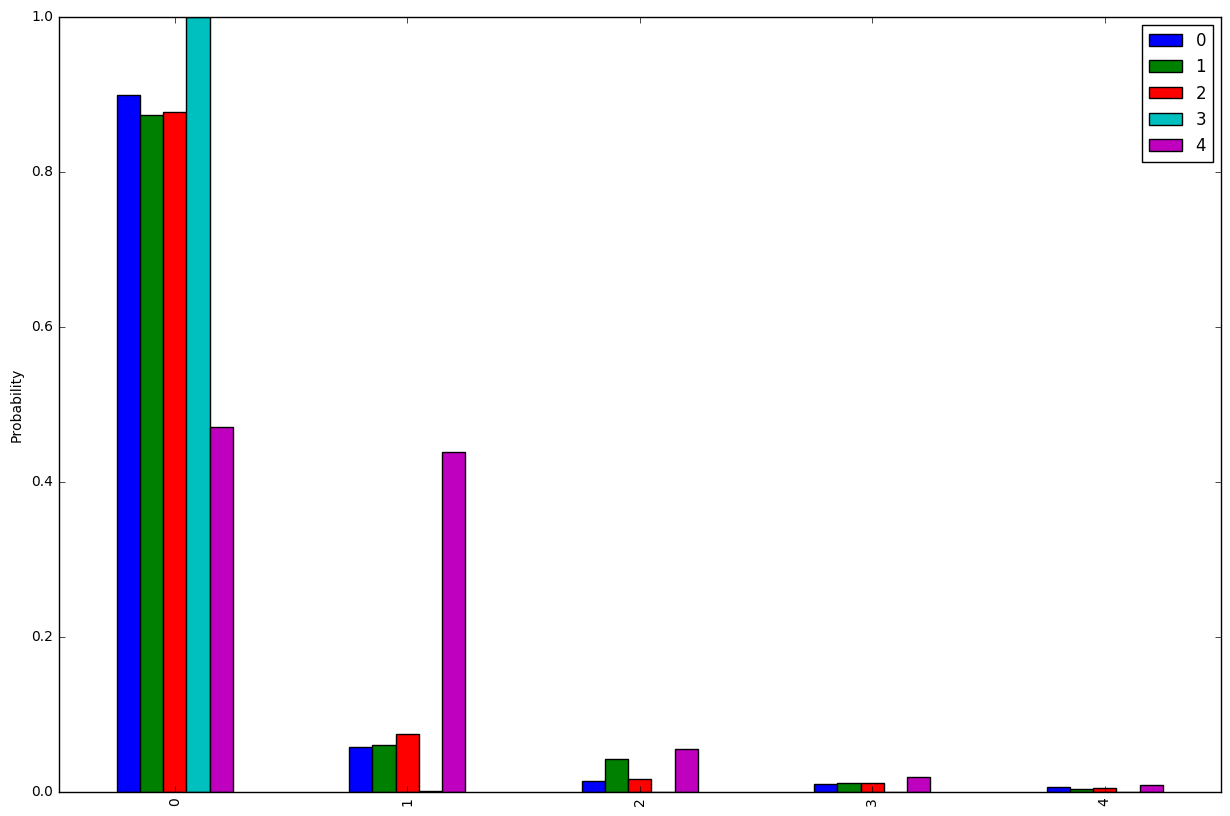

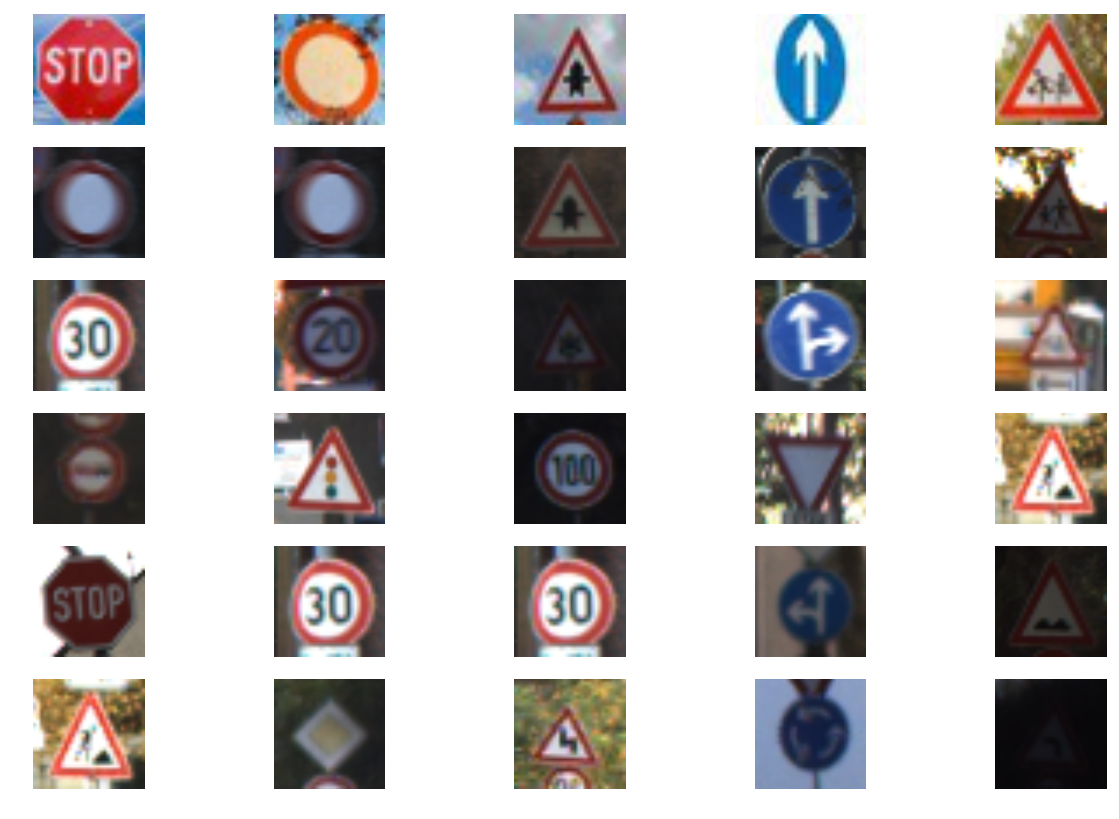

In [17]:
# Get top k performers
top_k = sess.run(tf.nn.top_k(prediction , k=5), feed_dict={x: X_mine})

top_k_t = pd.DataFrame(top_k.values.transpose())
top_k_t.plot(kind='bar').set_ylabel('Probability')

print(top_k.values)
print(top_k.indices)

fig = plt.figure()
for i in [1,2,3,4,5]:
    fig.add_subplot(6,5,i)
    plt.imshow(X[i-1,:,:,:]) 
    plt.axis('off')
    for j in [0,1,2,3,4]:
      fig.add_subplot(6,5,i+(j+1)*5)
      plt.imshow(traffic_sign[top_k.indices[i-1][j]])
      plt.axis('off')

### Certainty of Predictions

The model is fairly certain about the "Right-of-way at next intersection" and "Ahead only" signs with probabilities above 99%. The model was fairly certain about the "Student Crossing" sign. There was quite a bit of uncertainty about the other 2 signs.
For the "No Vehicles" sign, the model gave the incorrect output. The correct output did not even appear in the top 5. As noted about, this was expected since the colors did not match the training dataset.